In [1]:
import pandas as pd
from pandas import option_context
import numpy as np
from tqdm import tqdm
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
import skops.io as sio

from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc

import activity_features_all as atf
# import important_features as atf
import GenerateActivities as gat

from scipy.stats import mannwhitneyu
import cliffsDelta as cd

## Testing the best model

In [2]:
RAND_SEED = 7
SPLIT = 0.4

In [3]:
'''
Important features of the data
'''
important_features = ['feat_num_activities',
 'feat_num_activity_type',
 'feat_owner',
 'feat_ratio_owner_repo',
 'consecutive_activity_time_mean',
 'consecutive_activity_time_50%',
 'consecutive_activity_time_std',
 'consecutive_activity_time_gini',
 'activity_per_repo_mean',
 'activity_per_repo_50%',
 'activity_per_repo_gini',
 'activity_per_repo_IQR',
 'activity_type_per_repo_mean',
 'activity_type_per_repo_50%',
 'activity_type_per_repo_std',
 'activity_type_per_repo_gini',
 'continuous_activity_repo_mean',
 'continuous_activity_repo_std',
 'continuous_activity_repo_IQR',
 'time_spent_in_repo_mean',
 'time_spent_in_repo_50%',
 'time_spent_in_repo_std',
 'time_spent_in_repo_IQR',
 'time_to_switch_repo_mean',
 'time_to_switch_repo_50%',
 'time_to_switch_repo_std',
 'time_to_switch_repo_gini',
 'time_to_switch_repo_IQR',
 'time_to_switch_act_type_mean',
 'time_to_switch_act_type_50%',
 'time_to_switch_act_type_std',
 'time_to_switch_act_type_gini',
 'time_to_switch_act_type_IQR',
 'activity_per_act_type_mean',
 'activity_per_act_type_50%',
 'activity_per_act_type_std',
 'activity_per_act_type_gini',
 'activity_per_act_type_IQR']

## Reading features and splitting it into training and test set - same seed used for grid search

In [4]:
df_features_read = pd.read_csv('../data/features0305.csv',index_col=0).sort_index()

In [5]:
ground_truth = pd.read_csv('../data/total_contributors_with_dataset.csv').set_index('contributor')

In [6]:
df_features = (
               df_features_read
               .merge(ground_truth.drop('dataset',axis=1), left_index=True, right_index=True)
               .assign(bot = lambda d: np.where(d.acc_type_y == "human", 0, 1))
               .drop(['acc_type_x', 'acc_type_y'],axis=1)
               .assign(contributor = lambda d: d.index.str.replace('[bot]','',regex=False))
               .set_index('contributor')
               .sort_index()
              )
with option_context('display.max_column',None):
    display(df_features.query('bot == 1'))

,feat_num_activities,feat_num_activity_type,feat_repos,feat_owner,feat_ratio_owner_repo,consecutive_activity_time_mean,consecutive_activity_time_50%,consecutive_activity_time_std,consecutive_activity_time_gini,consecutive_activity_time_IQR,activity_per_repo_mean,activity_per_repo_50%,activity_per_repo_std,activity_per_repo_gini,activity_per_repo_IQR,activity_type_per_repo_mean,activity_type_per_repo_50%,activity_type_per_repo_std,activity_type_per_repo_gini,activity_type_per_repo_IQR,continuous_activity_repo_mean,continuous_activity_repo_50%,continuous_activity_repo_std,continuous_activity_repo_gini,continuous_activity_repo_IQR,time_spent_in_repo_mean,time_spent_in_repo_50%,time_spent_in_repo_std,time_spent_in_repo_gini,time_spent_in_repo_IQR,time_to_switch_repo_mean,time_to_switch_repo_50%,time_to_switch_repo_std,time_to_switch_repo_gini,time_to_switch_repo_IQR,time_to_switch_act_type_mean,time_to_switch_act_type_50%,time_to_switch_act_type_std,time_to_switch_act_type_gini,time_to_switch_act_type_IQR,activity_per_act_type_mean,activity_per_act_type_50%,activity_per_act_type_std,activity_per_act_type_gini,activity_per_act_type_IQR,bot
contributor,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1gtm,299,3,23,4,0.174,0.081,0.000,0.679,0.970,0.003,13.000,8.0,13.655,0.490,10.00,1.957,2.0,0.367,0.062,0.0,6.795,3.0,9.849,0.567,4.25,0.206,0.001,1.275,0.956,0.010,0.352,0.017,1.212,0.897,0.045,0.017,0.000,0.191,0.950,0.001,99.667,146.0,85.500,0.337,75.50,1
24emebot,279,1,1,1,1.000,7.589,0.584,15.767,0.786,6.146,279.000,279.0,0.000,0.000,0.00,1.000,1.0,0.000,0.000,0.0,279.000,279.0,0.000,0.000,0.00,2109.750,2109.750,0.000,0.000,0.000,NaN,NaN,0.000,0.000,NaN,NaN,NaN,0.000,0.000,NaN,279.000,279.0,0.000,0.000,0.00,1
47erbot,201,7,12,3,0.250,1.930,0.003,9.800,0.960,0.012,16.750,12.0,15.058,0.392,8.50,4.667,5.0,1.231,0.095,0.0,2.871,3.0,1.710,0.275,1.00,1.237,0.000,7.341,0.965,0.004,4.339,0.012,14.939,0.927,0.020,2.013,0.001,10.149,0.958,0.010,28.714,31.0,12.945,0.215,6.50,1
5imon-bot,56,1,3,1,0.333,36.690,0.311,76.716,0.813,26.075,18.667,8.0,19.348,0.405,17.00,1.000,1.0,0.000,0.000,0.0,4.308,1.0,8.430,0.629,2.00,33.451,0.000,62.265,0.519,45.408,131.922,114.406,115.178,0.456,134.859,NaN,NaN,0.000,0.000,NaN,56.000,56.0,0.000,0.000,0.00,1
9cibot,27,2,1,1,1.000,38.672,0.097,112.949,0.864,0.215,27.000,27.0,0.000,0.000,0.00,2.000,2.0,0.000,0.000,0.0,27.000,27.0,0.000,0.000,0.00,1005.467,1005.467,0.000,0.000,0.000,NaN,NaN,0.000,0.000,NaN,10.420,0.048,41.244,0.884,0.102,13.500,13.5,7.778,0.204,5.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zksync-admin-bot2,51,4,5,1,0.200,41.947,0.560,97.237,0.820,39.724,10.200,3.0,11.584,0.518,14.00,2.400,2.0,0.548,0.100,1.0,3.923,3.0,3.201,0.395,3.00,34.610,0.196,94.986,0.827,12.673,137.286,86.892,159.089,0.535,95.312,43.350,0.095,108.175,0.848,13.403,12.750,13.5,5.909,0.221,5.75,1
zorro-bot,85,3,1,1,1.000,25.382,11.938,39.925,0.660,26.623,85.000,85.0,0.000,0.000,0.00,3.000,3.0,0.000,0.000,0.0,85.000,85.0,0.000,0.000,0.00,2132.089,2132.089,0.000,0.000,0.000,NaN,NaN,0.000,0.000,NaN,30.598,17.293,41.522,0.584,30.556,28.333,8.0,38.734,0.541,34.50,1
zube,43,3,7,5,0.714,12.025,1.843,21.076,0.746,12.083,6.143,1.0,7.034,0.545,9.50,1.429,1.0,0.535,0.171,1.0,2.389,1.0,2.429,0.443,1.00,9.460,0.000,26.561,0.717,0.015,19.693,6.962,28.264,0.655,14.387,12.800,6.231,21.420,0.698,6.705,14.333,4.0,19.655,0.543,17.50,1


In [7]:
df_features.columns[df_features.isna().any()]

Index(['time_to_switch_repo_mean', 'time_to_switch_repo_50%',
       'time_to_switch_repo_IQR', 'time_to_switch_act_type_mean',
       'time_to_switch_act_type_50%', 'time_to_switch_act_type_IQR'],
      dtype='object')

In [8]:
df_features.bot.value_counts()

0    1115
1    1035
Name: bot, dtype: int64

## Reading important features from x_test and labels from y_test

In [9]:
'''
Mapping column names to their abbreviations
'''

columns = {'feat_num_activities':'NA',
           'feat_num_activity_type':'NT',
           'feat_repos':'NR',
           'feat_owner':'NOR',
           'feat_ratio_owner_repo':'ORR',
           
           'consecutive_activity_time_mean':'DCA_mean',
           'consecutive_activity_time_50%':'DCA_median',
           'consecutive_activity_time_std':'DCA_std',
           'consecutive_activity_time_gini':'DCA_gini',
           'consecutive_activity_time_IQR':'DCAR_IQR',
           
           'activity_per_repo_mean':'NAR_mean',
           'activity_per_repo_50%':'NAR_median',
           'activity_per_repo_std':'NAR_std',
           'activity_per_repo_gini':'NAR_gini',
           'activity_per_repo_IQR':'NAR_IQR',
           
           'activity_type_per_repo_mean':'NTR_mean',
           'activity_type_per_repo_50%':'NTR_median',
           'activity_type_per_repo_std':'NTR_std',
           'activity_type_per_repo_gini':'NTR_gini',
           'activity_type_per_repo_IQR':'NTR_IQR',
           
           'continuous_activity_repo_mean':'NCAR_mean',
           'continuous_activity_repo_50%':'NCAR_median',
           'continuous_activity_repo_std':'NCAR_std',
           'continuous_activity_repo_gini':'NCAR_gini',
           'continuous_activity_repo_IQR':'NCAR_IQR',
           
           'time_spent_in_repo_mean':'DCAR_mean',
           'time_spent_in_repo_50%':'DCAR_median',
           'time_spent_in_repo_std':'DCAR_std',
           'time_spent_in_repo_gini':'DCAR_gini',
           'time_spent_in_repo_IQR':'DCAR_IQR',
           
           'time_to_switch_repo_mean':'DAAR_mean',
           'time_to_switch_repo_50%':'DAAR_median',
           'time_to_switch_repo_std':'DAAR_std',
           'time_to_switch_repo_gini':'DAAR_gini',
           'time_to_switch_repo_IQR':'DAAR_IQR',
           
           'time_to_switch_act_type_mean':'DCAT_mean',
           'time_to_switch_act_type_50%':'DCAT_median',
           'time_to_switch_act_type_std':'DCAT_std',
           'time_to_switch_act_type_gini':'DCAT_gini',
           'time_to_switch_act_type_IQR':'DCAT_IQR',
           
           'activity_per_act_type_mean':'NAT_mean',
           'activity_per_act_type_50%':'NAT_median',
           'activity_per_act_type_std':'NAT_std',
           'activity_per_act_type_gini':'NAT_gini',
           'activity_per_act_type_IQR':'NAT_IQR'}

In [10]:
y_test = pd.read_csv('../data/test_label.csv',index_col=0)
x_test_impt = (
    pd.read_csv('../data/test_feat.csv',index_col=0)
    [important_features]
    .rename(columns=columns)
)
x_test_impt

,NA,NT,NOR,ORR,DCA_mean,DCA_median,DCA_std,DCA_gini,NAR_mean,NAR_median,...,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR,NAT_mean,NAT_median,NAT_std,NAT_gini,NAT_IQR
contributor,,,,,,,,,,,,,,,,,,,,,
otc-zuul[bot],185,5,4,0.182,1.937,0.000,7.485,0.892,8.409,5.5,...,1.987,0.000,7.668,0.895,0.153,37.000,57.0,31.161,0.385,54.00
ljharb,245,16,31,0.492,0.932,0.059,2.618,0.846,3.889,2.0,...,1.037,0.047,2.916,0.855,0.472,15.312,7.0,20.480,0.608,11.75
juancarlospaco,126,13,20,0.541,13.648,0.331,28.672,0.807,3.405,1.0,...,13.389,0.303,26.708,0.792,14.841,9.692,4.0,11.870,0.591,12.00
tldr-bot,300,1,1,1.000,7.091,0.356,12.523,0.767,300.000,300.0,...,NaN,NaN,0.000,0.000,NaN,300.000,300.0,0.000,0.000,0.00
jakirkham,262,12,18,0.273,0.219,0.024,1.036,0.869,3.970,2.0,...,0.278,0.026,1.250,0.878,0.089,21.833,8.0,30.322,0.601,17.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mmstick,259,11,2,0.095,1.960,0.051,6.153,0.872,12.333,5.0,...,1.957,0.026,6.569,0.880,0.698,23.545,20.0,19.922,0.397,15.50
asyncapi-bot,298,4,1,0.333,0.009,0.003,0.069,0.676,99.333,4.0,...,0.557,0.753,0.489,0.366,0.459,74.500,2.0,145.670,0.737,74.50
jeffgbutler,150,12,2,0.182,14.016,0.163,35.470,0.840,13.636,4.0,...,13.433,0.097,37.792,0.867,4.093,12.500,5.5,19.829,0.647,11.75


In [11]:
y_test.bot.value_counts()

0    446
1    414
Name: bot, dtype: int64

## Model testing

In [12]:
'''
Performance metrics
'''
def botrecall(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,zero_division=0.0)[1][1]
bot_recall = make_scorer(botrecall, greater_is_better=True)

def humanrecall(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,zero_division=0.0)[1][0]
human_recall = make_scorer(humanrecall, greater_is_better=True)

def botprecision(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,zero_division=0.0)[0][1]
bot_precision = make_scorer(botprecision, greater_is_better=True)

def humanprecision(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,zero_division=0.0)[0][0]
human_precision = make_scorer(humanprecision, greater_is_better=True)

def wpscore(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,average='weighted',zero_division=0.0)[0]
wprecision_score = make_scorer(wpscore, greater_is_better=True)

def wrscore(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,average='weighted',zero_division=0.0)[1]
wrecall_score = make_scorer(wrscore, greater_is_better=True)

def auc_pr(y_true, y_pred):
    P, R, T = precision_recall_curve(y_true, y_pred)
    return(auc(R, P))
auc_pr = make_scorer(auc_pr, greater_is_better=True)

In [13]:
def testing_model(x_test, y_test, model):
    '''
    args: x_test - DataFrame; contributor behavioural features
          y_test - array; contributor type
          model - method; the trained model

    returns: performance - dict; performance metric vlues
             y_pred - array; prediction values given by the model
    '''
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        y_pred = model.predict(x_test)
    
    y_true = y_test
    performance = {'precision': [precision_score(y_test, y_pred, average='weighted', zero_division=0.0)],
                   'bot_precision': [botprecision(y_test, y_pred)],
                   'human_precision': [humanprecision(y_test, y_pred)],
                   'recall': [recall_score(y_test, y_pred, average='weighted', zero_division=0.0)],
                   'bot_recall': [botrecall(y_test, y_pred)],
                   'human_recall': [humanrecall(y_test, y_pred)],
                   'weighted_f1': [f1_score(y_test, y_pred, average='weighted', zero_division=0.0)],
                   'accuracy': [accuracy_score(y_test, y_pred)],
                   'tn_fp_fn_tp': [confusion_matrix(y_test, y_pred).ravel()],
                   'num_contrib': x_test.index.nunique(),
                   'roc_auc': [roc_auc_score(y_test, y_pred)]
                  }
    
    return(performance, y_pred)

In [14]:
'''
Load the bot identification model
'''
bimbas = sio.load('bimbas.skops', trusted=True)

In [15]:
performance, y_pred = testing_model(x_test_impt,y_test['bot'].values,model=bimbas)
performance_df = pd.DataFrame.from_dict(performance)
performance_df

,precision,bot_precision,human_precision,recall,bot_recall,human_recall,weighted_f1,accuracy,tn_fp_fn_tp,num_contrib,roc_auc
0,0.899316,0.882904,0.91455,0.898837,0.910628,0.887892,0.898871,0.898837,"[396, 50, 37, 377]",860,0.89926


In [16]:
'''
FP analysis
'''
FP = (
    x_test_impt.assign(pred = y_pred)
    .merge(y_test, left_index=True, right_index=True)
    .merge(ground_truth, left_index=True, right_index=True)
    .query('pred == 1 and bot == 0')
    [['pred','bot']+x_test_impt.columns.to_list()]
)
with option_context('display.max_column',None):
    display(FP.head(10))

,pred,bot,NA,NT,NOR,ORR,DCA_mean,DCA_median,DCA_std,DCA_gini,NAR_mean,NAR_median,NAR_gini,NAR_IQR,NTR_mean,NTR_median,NTR_std,NTR_gini,NCAR_mean,NCAR_std,NCAR_IQR,DCAR_mean,DCAR_median,DCAR_std,DCAR_IQR,DAAR_mean,DAAR_median,DAAR_std,DAAR_gini,DAAR_IQR,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR,NAT_mean,NAT_median,NAT_std,NAT_gini,NAT_IQR
contributor,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
foreign-sub,1,0,18,3,1,1.000,104.475,0.164,153.856,0.697,18.000,18.0,0.000,0.0,3.000,3.0,0.000,0.000,18.000,0.000,0.00,1776.082,1776.082,0.000,0.000,NaN,NaN,0.000,0.000,NaN,57.169,0.062,116.933,0.813,1.717,6.000,6.0,3.000,0.222,3.00
andriifilippov,1,0,106,4,1,0.500,20.471,1.387,44.019,0.776,53.000,53.0,0.038,4.0,3.000,3.0,0.000,0.000,5.579,4.880,5.50,60.463,19.151,121.312,55.207,55.595,22.738,81.898,0.637,67.092,15.201,1.942,29.549,0.754,20.196,26.500,16.5,22.428,0.340,14.00
apiology,1,0,69,5,1,0.500,30.122,0.021,115.230,0.934,34.500,34.5,0.442,30.5,4.500,4.5,0.707,0.056,23.000,27.074,25.00,385.765,452.302,357.131,352.452,445.504,445.504,49.454,0.039,34.969,31.034,0.019,116.867,0.932,0.047,13.800,14.0,0.837,0.029,1.00
tkishel,1,0,24,4,1,0.500,14.849,0.010,46.703,0.901,12.000,12.0,0.000,0.0,4.000,4.0,0.000,0.000,12.000,0.000,0.00,130.827,130.827,183.932,130.059,79.869,79.869,0.000,0.000,0.000,20.053,0.019,53.747,0.862,0.169,6.000,5.0,2.828,0.208,3.00
mreiferson,1,0,11,6,1,1.000,203.807,0.026,644.377,0.900,11.000,11.0,0.000,0.0,6.000,6.0,0.000,0.000,11.000,0.000,0.00,2038.072,2038.072,0.000,0.000,NaN,NaN,0.000,0.000,NaN,0.038,0.016,0.048,0.579,0.045,1.833,1.5,0.983,0.258,1.75
shady-robot,1,0,5,5,1,1.000,0.144,0.015,0.268,0.632,5.000,5.0,0.000,0.0,5.000,5.0,0.000,0.000,5.000,0.000,0.00,0.574,0.574,0.000,0.000,NaN,NaN,0.000,0.000,NaN,0.144,0.015,0.268,0.632,0.158,1.000,1.0,0.000,0.000,0.00
vlad-ion,1,0,12,3,1,1.000,0.035,0.008,0.048,0.580,12.000,12.0,0.000,0.0,3.000,3.0,0.000,0.000,12.000,0.000,0.00,0.389,0.389,0.000,0.000,NaN,NaN,0.000,0.000,NaN,0.004,0.004,0.005,0.000,0.004,4.000,1.0,5.196,0.500,4.50
pietroalbini,1,0,300,2,2,0.667,0.029,0.011,0.043,0.647,100.000,1.0,0.660,148.5,1.000,1.0,0.000,0.000,60.000,81.228,65.00,1.694,0.967,2.711,1.046,0.035,0.034,0.008,0.108,0.012,0.034,0.034,0.007,0.076,0.005,150.000,150.0,210.718,0.497,149.00
rgerum,1,0,299,2,1,0.333,0.774,0.047,2.476,0.881,99.667,12.0,0.609,136.5,1.333,1.0,0.577,0.167,13.591,21.766,8.25,6.704,0.054,14.843,2.640,3.957,1.931,4.597,0.599,5.936,4.950,4.950,5.323,0.380,3.764,149.500,149.5,210.011,0.497,148.50


In [17]:
'''
FN analysis
'''
FN = (
    x_test_impt.assign(pred = y_pred)
    .merge(y_test, left_index=True, right_index=True)
    .merge(ground_truth, left_index=True, right_index=True)
    .query('pred==0 and bot == 1')
    [['pred','bot']+x_test_impt.columns.to_list()]
)
with option_context('display.max_column',None):
    display(FN.head(10))

,pred,bot,NA,NT,NOR,ORR,DCA_mean,DCA_median,DCA_std,DCA_gini,NAR_mean,NAR_median,NAR_gini,NAR_IQR,NTR_mean,NTR_median,NTR_std,NTR_gini,NCAR_mean,NCAR_std,NCAR_IQR,DCAR_mean,DCAR_median,DCAR_std,DCAR_IQR,DAAR_mean,DAAR_median,DAAR_std,DAAR_gini,DAAR_IQR,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR,NAT_mean,NAT_median,NAT_std,NAT_gini,NAT_IQR
contributor,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
eclipse-metro-bot,0,1,6,4,1,1.000,77.967,0.001,174.312,0.800,6.000,6.0,0.000,0.00,4.000,4.0,0.000,0.000,6.000,0.000,0.00,389.832,389.832,0.000,0.000,NaN,NaN,0.000,0.000,NaN,77.967,0.001,174.312,0.800,0.046,1.500,1.5,0.577,0.167,1.00
mqube-bot,0,1,189,8,1,0.125,4.486,0.004,26.361,0.969,23.625,22.0,0.116,2.00,7.625,8.0,0.518,0.031,1.989,2.403,1.00,2.049,0.000,14.008,0.004,6.902,0.001,35.008,0.954,0.019,5.280,0.005,29.333,0.968,0.033,23.625,22.0,9.303,0.181,4.25
centeredgebot[bot],0,1,22,3,1,0.091,75.193,0.286,287.282,0.925,2.000,2.0,0.281,1.00,1.091,1.0,0.302,0.076,1.294,1.213,0.00,0.918,0.000,3.784,0.000,97.716,0.308,328.272,0.909,8.768,221.786,2.677,535.635,0.828,9.024,7.333,3.0,7.506,0.394,6.50
jersey-bot,0,1,35,6,1,0.500,31.343,0.262,113.721,0.886,17.500,17.5,0.271,9.50,3.500,3.5,3.536,0.357,3.500,3.028,4.00,105.653,0.427,207.296,145.736,1.015,0.174,2.482,0.802,0.202,35.231,0.196,120.756,0.872,9.307,5.833,5.0,2.994,0.243,1.50
staging[bot],0,1,28,2,4,0.667,70.015,1.498,104.674,0.685,4.667,3.0,0.500,3.50,1.167,1.0,0.408,0.119,4.000,4.243,3.00,163.295,1.499,249.419,249.769,124.558,108.860,70.979,0.289,106.268,111.305,111.305,157.409,0.500,111.305,14.000,14.0,18.385,0.464,13.00
pr-scheduler[bot],0,1,30,4,6,1.000,72.566,11.000,137.920,0.724,5.000,5.5,0.222,2.50,2.000,2.0,0.894,0.222,2.727,1.348,2.00,115.486,4.730,205.074,158.729,83.408,58.020,100.170,0.536,86.105,89.982,4.722,182.031,0.718,84.078,7.500,6.0,7.506,0.467,10.00
erda-bot,0,1,145,6,2,0.333,11.485,0.194,29.142,0.863,24.167,6.5,0.677,4.75,2.667,2.0,1.506,0.271,4.833,6.608,3.25,46.468,0.129,147.162,3.982,8.958,0.790,16.637,0.759,16.036,11.071,0.143,29.680,0.878,1.984,24.167,19.5,23.558,0.477,40.00
dangerpr-bot,0,1,17,1,6,0.750,125.492,111.623,124.391,0.475,2.125,1.0,0.419,1.00,1.000,1.0,0.000,0.000,1.700,0.823,1.00,64.463,0.134,113.179,46.791,151.470,104.597,156.820,0.505,137.288,NaN,NaN,0.000,0.000,NaN,17.000,17.0,0.000,0.000,0.00
meshery[bot],0,1,17,1,12,0.706,119.808,82.554,136.091,0.556,1.000,1.0,0.000,0.00,1.000,1.0,0.000,0.000,1.000,0.000,0.00,0.000,0.000,0.000,0.000,119.808,82.554,136.091,0.556,156.688,NaN,NaN,0.000,0.000,NaN,17.000,17.0,0.000,0.000,0.00


### Getting important features using permutation importances

In [18]:
# get the order of importance using permutation importance
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    feature_importance = permutation_importance(bimbas,
                                                x_test_impt,
                                                y_test['bot'].values,
                                                scoring={
                                                         'f1_macro':'f1_macro',
                                                         'f1_weighted':'f1_weighted',
                                                         'precision':wprecision_score,
                                                         'recall':wrecall_score,
                                                         'roc_auc':'roc_auc'
                                                        },
                                                n_repeats=10,
                                                random_state=RAND_SEED)

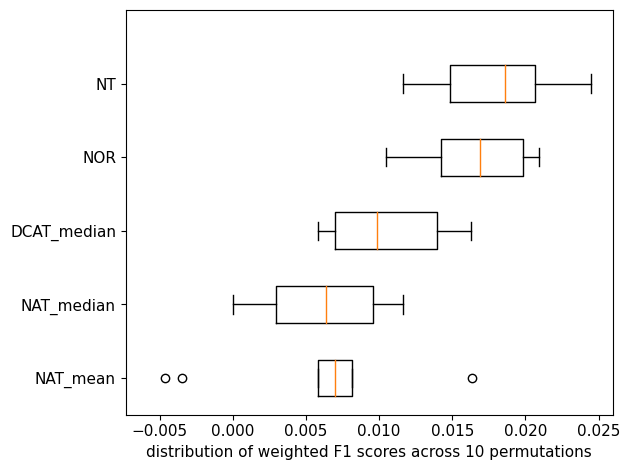

In [19]:
metric='f1_weighted'
cols_rename={'feat_num_activity_type':'NT',
             'feat_owner':'NOR',
             'activity_per_act_type_mean':'NAT_mean',
             'time_to_switch_act_type_50%':'DCAT_median',
             'activity_per_act_type_50%':'NAT_median',
             'feat_ratio_owner_repo':'ORR',
             'consecutive_activity_time_50%':'DCA_median',
             'time_to_switch_act_type_std':'DCAT_std',
             'time_to_switch_repo_50%':'DAAR_median',
             'activity_type_per_repo_mean':'NTR_mean',
             'activity_type_per_repo_std':'NTR_std'}

fimp_sorted_idx = feature_importance[metric].importances_mean.argsort()
plt.boxplot(feature_importance['f1_weighted'].importances[fimp_sorted_idx].T,
            vert=False,
            labels=x_test_impt.rename(columns=cols_rename).keys()[fimp_sorted_idx])
plt.xlabel(xlabel='distribution of weighted F1 scores across 10 permutations',fontsize=11)
plt.ylim(33.5,39)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
# plt.savefig('../../notebooks_scripts/Plots/feature_importance_test.pdf')
plt.show()

In [20]:
def myMannWhitneyU(df, feature, val1='bot', val2='human', alpha=0.001/38):
    '''
    args: df - DataFrame; dataframe that needs to be processed
          feature - str; the feature that needs to be analysed
          sep_field - str; the field on which the dataframe has to be divided
          val1 - str; the value of the 1st field to get the list of numbers corresponding to that value
          val2 - str; the value of the 2nd field to get the list of numbers corresponding to that value
          alpha - float; the level of significance
    
    return: p - float; the probability value
            stat - float; the statistic U
            decision - str; the decision if null hypothesis is rejected or not
            d - float; the cliffs delta's difference value
            size - str; the size cliff's delta's difference - negligible, small, medium, large
    
    Method: perform Mann Whitney U test and report the effect size
    '''
    
    set1 = df.query('bot == @val1')[feature].dropna()
    set2 = df.query('bot == @val2')[feature].dropna()
    stat, p = mannwhitneyu(set1, set2)
    
    d,size=cd.cliffsDelta(set1,set2)
    if p<alpha:
        decision = f'With alpha={alpha}, Reject null hypothesis - They have significant difference'
    else:
        decision = f'With alpha={alpha}, Null hypothesis (They have significant difference) cannot be rejected'
    
    bot_med = set1.describe()['50%']
    hum_med = set2.describe()['50%']
    return(p, stat, decision, d, size, bot_med, hum_med)

In [21]:
## median value for the observed important features
df_test_set = x_test_impt.merge(y_test, left_index=True, right_index=True, how='inner')
# plot_features = df_important_features.keys().to_list()
plot_features = ['NT',
                 'NOR',
                 'DCAT_median',
                 'NAT_median',
                 'NAT_mean']
for plot_feature in plot_features:
    set_bot = df_test_set.query('bot == 1')[plot_feature].dropna()
    set_hum = df_test_set.query('bot == 0')[plot_feature].dropna()
    pv, stat, decision, d, size, bot_med, human_med = myMannWhitneyU(df_test_set, plot_feature, 1, 0)
    # d,size=cd.cliffsDelta(set_bot,set_hum)
    
    print(f"{plot_feature}")
    print(f'p-value: {pv}, decision: {decision}')
    print(f"delta: {d}, size: {size}")
    print(f"median values: \nbot: {bot_med}, \
    human: {human_med}\n")

NT
p-value: 5.3884786963570784e-76, decision: With alpha=2.6315789473684212e-05, Reject null hypothesis - They have significant difference
delta: -0.7247893243213969, size: large
median values: 
bot: 4.0,     human: 10.0

NOR
p-value: 2.4680777583987033e-47, decision: With alpha=2.6315789473684212e-05, Reject null hypothesis - They have significant difference
delta: -0.5544615584584389, size: large
median values: 
bot: 1.0,     human: 4.0

DCAT_median
p-value: 1.532716588651118e-30, decision: With alpha=2.6315789473684212e-05, Reject null hypothesis - They have significant difference
delta: -0.48153009050392365, size: large
median values: 
bot: 0.003,     human: 0.125

NAT_median
p-value: 5.231829043730823e-66, decision: With alpha=2.6315789473684212e-05, Reject null hypothesis - They have significant difference
delta: 0.6761985225623361, size: large
median values: 
bot: 29.5,     human: 6.0

NAT_mean
p-value: 3.918338314363224e-71, decision: With alpha=2.6315789473684212e-05, Reject n